In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pandas as pd
import itertools
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [ ]:
Train="/content/drive/MyDrive/3classnew/Old"                    # a Path for data set 
Test= "/content/drive/MyDrive/3classnew/OldTest"

In [ ]:
# A function that resizes and imports as color image  
import keras
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath,cv2.IMREAD_COLOR), (224, 224))
            image = cv2.cvtColor(image , cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

uniq_labels = sorted(os.listdir(Train))
image, labels = load_images(directory = Train)
if uniq_labels == sorted(os.listdir(Test)):
  X_test, y_test = load_images(directory = Test)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(image,labels, test_size =0.2, stratify = labels) # spliting data set 
                                                                                                     # for train and validation

In [ ]:
print("The size of training dataset is: ", X_train.shape)
print("The size of validation dataset is: ", X_eval.shape)
print("The size of testing dataset is: ", X_test.shape)
print("The size of training dataset y is: ", y_train.shape)
print("The size of evalation dataset y is: ", y_eval.shape)
print("The size of testing dataset y is: ", y_test.shape)


The size of training dataset is:  (692, 224, 224, 3)
The size of validation dataset is:  (173, 224, 224, 3)
The size of testing dataset is:  (865, 224, 224, 3)
The size of training dataset y is:  (692,)
The size of evalation dataset y is:  (173,)
The size of testing dataset y is:  (865,)


In [ ]:
# Normilizing X train datas
X_train = X_train.astype('float32')/255.0             
X_eval= X_eval.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0


In [ ]:
# Converting to one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_eval = to_categorical(y_eval)

In [ ]:
# a function for data agumentation
train_datagen = ImageDataGenerator(rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.2, 
    zoom_range=0.10, 
     shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest")


In [ ]:
# Data Agumenting 
Train_data=train_datagen.flow(X_train,y_train,batch_size=21,shuffle=True)
Evalu_data=train_datagen.flow(X_eval,y_eval,batch_size=21,shuffle=True)
Test_data=train_datagen.flow(X_test,y_test,batch_size=21,shuffle=True)


In [ ]:
# Importing CNN network models with excluding top layer
Model_vgg16 = VGG16(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_mNetV2 = MobileNetV2(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_resnet = ResNet50(input_shape= (224,224,3),include_top=False,weights='imagenet',classes=3)
Model_InceptionV3=InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet',classes=3)

In [ ]:
# freezing layers 
for layer in Model_vgg16.layers:
    layer.trainable = False
for layer in Model_mNetV2.layers:
    layer.trainable = False
for layer in Model_resnet.layers:
    layer.trainable = False
for layer in Model_InceptionV3.layers:
    layer.trainable = False


In [ ]:
# top layer for VGG16 layers 
model1 = Model_vgg16.output
model1 = Flatten()(model1)
model1 = Dense(units=256, activation='relu')(model1)
model1 = Dropout(0.6)(model1)
model1 = Dense(units=3, activation='softmax')(model1)
model_VGG16 = Model(inputs = Model_vgg16.input , outputs = model1)
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# top layer for mobilenetV2 layers 
model2 = Model_mNetV2.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.6)(model2)
model2  = Dense(3, activation='softmax')(model2)
model2_mNetV2= Model(inputs = Model_mNetV2.input , outputs = model2)
model2_mNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# top layer for resnet layers 
model3 = Model_resnet.output
model3 = Flatten()(model3)
model3 = Dropout(0.6)(model3)
model3 = Dense(units=3, activation='softmax')(model3)
model3_resnet= Model(inputs = Model_resnet.input , outputs = model3)
model3_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# top layer for Inception V3 layers 
model4 = Model_InceptionV3.output#head mode
model4 = Flatten()(model4)
model4 = Dense(units=1024, activation='relu')(model4)
model4 = Dropout(0.6)(model4)
model4 = Dense(units=3, activation='softmax')(model4)
model4_InceptionV3= Model(inputs = Model_InceptionV3.input , outputs = model4)
model4_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.01) # learning rate reduction

In [ ]:
history2 = model_VGG16.fit(Train_data,epochs=5,batch_size= 2,validation_data=Evalu_data,callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                        learning_rate_reduction
                    ])

Epoch 1/5
33/33 [==============================] - 445s 14s/step - loss: 1.7784 - accuracy: 0.6228 - val_loss: 0.1701 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/5
33/33 [==============================] - 444s 14s/step - loss: 0.2226 - accuracy: 0.9277 - val_loss: 0.1067 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 3/5
33/33 [==============================] - 440s 13s/step - loss: 0.1415 - accuracy: 0.9566 - val_loss: 0.0569 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4/5
33/33 [==============================] - 446s 14s/step - loss: 0.1009 - accuracy: 0.9740 - val_loss: 0.0526 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 5/5
33/33 [==============================] - 445s 14s/step - loss: 0.1044 - accuracy: 0.9639 - val_loss: 0.0620 - val_accuracy: 0.9769 - lr: 0.0010


In [ ]:
 model_VGG16.save('/content/drive/MyDrive/3classnew/VGG6_3c.h5')  # saving model

In [ ]:
score = model_VGG16.evaluate(x= X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model_VGG16.evaluate(Evalu_data, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.422 %
Accuracy for evaluation images: 96.532 %


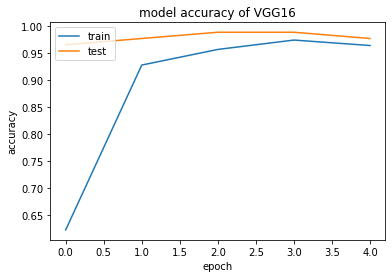

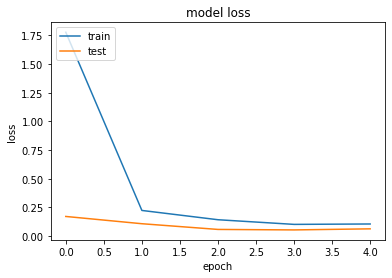

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (10, 10))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()


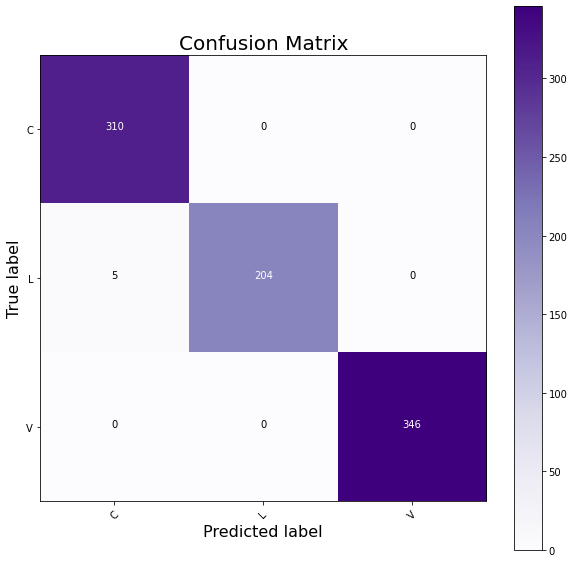

In [ ]:
y_test_pred = model_VGG16.predict(X_test, batch_size = 2, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
history32 = model3_resnet.fit(Train_data,epochs=5,batch_size= 2,validation_data=Evalu_data,callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                        learning_rate_reduction
                    ])

Epoch 1/5
33/33 [==============================] - 145s 4s/step - loss: 3.9604 - accuracy: 0.4798 - val_loss: 1.5223 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 2/5
33/33 [==============================] - 141s 4s/step - loss: 1.6679 - accuracy: 0.6647 - val_loss: 0.7977 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 3/5
33/33 [==============================] - 141s 4s/step - loss: 0.9995 - accuracy: 0.7514 - val_loss: 1.5749 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 4/5
33/33 [==============================] - 141s 4s/step - loss: 1.2924 - accuracy: 0.7486 - val_loss: 1.4951 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 5/5
33/33 [==============================] - 141s 4s/step - loss: 1.3418 - accuracy: 0.7486 - val_loss: 0.6757 - val_accuracy: 0.8613 - lr: 0.0010


In [ ]:
model3_resnet.save('/content/drive/MyDrive/3classnew/Resnet_3c.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
score = model3_resnet.evaluate(x= X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model3_resnet.evaluate(Evalu_data, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 91.214 %
Accuracy for evaluation images: 83.237 %


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (10, 10))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

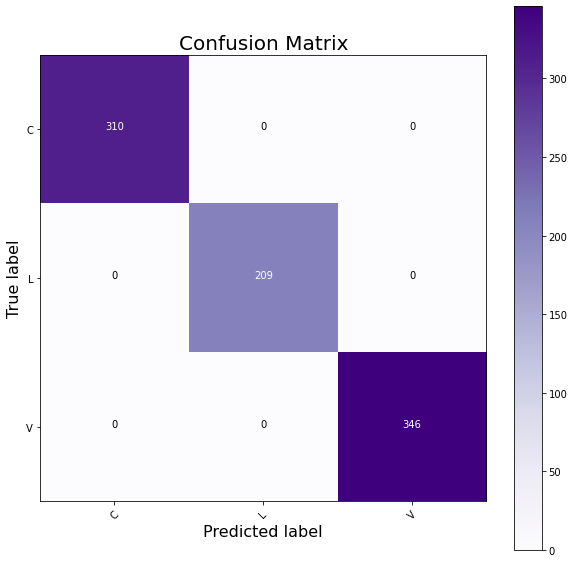

In [ ]:
y_test_pred = model3_resnet.predict(X_test, batch_size = 2, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)